# Sentiment Classification Using Logistic Regression

Here I will be implementing a naive bayes baseline classifier. Additionally, I will be using pytorch to implement a binary logistic regression classifier. Sentiment classification is performed on hotel reviews. The input to the model will be a text review, and the output label is a 1 or 0 marking it as positive or negative review.

There is a a util.py file for loading the data, and some of the basic modeling. 

Make sure to install all dependencies from requirements.txt file 
```
pip install -r requirements.txt
```

In [536]:
from typing import List
import spacy
import torch
import random

## Sentiment Classification Dataset

The training data for this task consists of a collection of hotel reviews. The data is formatted as one review per line. Each line starts with a unique identifier for the review (as in ID-2001) followed by tab and the text of the review.  The reviews are not tokenized or sentence segmented in any way (the words are space separated). The positive reviews and negative reviews appear in separate files namely [hotelPosT-train.txt](data/hotelPosT-train.txt) and [hotelNegT-train.txt](data/hotelNegT-train.txt).

In [537]:
from util import load_train_data
pos_datapath = "data/hotelPosT-train.txt"
neg_datapath = "data/hotelNegT-train.txt"
all_texts, all_labels = load_train_data(pos_datapath, neg_datapath)

### Lets look at what is in the data

In [538]:
def random_sample(texts, labels, label):
    data_by_label = {}
    for lab, text in zip(labels, texts):
        if lab not in data_by_label:
            data_by_label[lab] = []
        data_by_label[lab].append(text)
    return random.choice(data_by_label[label])

print("--- Positive Example ---")
print(random_sample(all_texts, all_labels, label=1))
print("\n--- Negative Example ---")
print(random_sample(all_texts, all_labels, label=0))

--- Positive Example ---
This hotel is very affordable when my family takes trips to Lake Mead. You can find affordable rooms all year long and it is a very short drive to the lake and to the Hoover Dam. There is a gas station across the street and a casino, bar, buffet, and restaurant downstairs. They also have ice machines that are conveniently located, a game room for the kids and a decent sized pool and jacuzzi. They also have car spots that are ideal for those parking their cars with trailers. They have a small theatre where they show movies at a low price. The customer service is great. When we had an issue with a barking dog next door, we were bumped up to a mini suite in the small tower. It was great! I definitely recommend this hotel to anyone visiting Lake Mead.

--- Negative Example ---
This hotel is located at a busy traffic circle near the interstate. It isn't walking distance to downtown. The hotel restaurant was average. My wife complained about the quality of the sheets

### Task 1.1: Print the number of "positive" and "negative" samples

It is important to know the distribution of the training examples. More often than not, you will have to work with datasets that are not "balanced" with respect to the labels of the samples. For this task, print out the number of examples that have label = 1 and label = 0, respectively, in std:out or plot a pie chart.

No. of positive reviews: 95
No. of negative reviews: 94


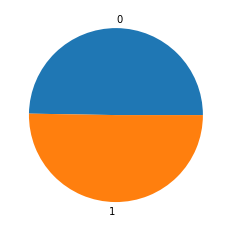

In [540]:
from matplotlib import pyplot as plt
import numpy as np

def label_distribution(labels):

    #  to print the labels distribution.
    
    print(f'No. of positive reviews: {sum(1 for x in labels if x == 1 )}')
    print(f'No. of negative reviews: {labels.count(0)}')
    cat_labels= [0, 1]
    cat_val = [labels.count(0), labels.count(1)]
    plt.pie(cat_val, labels = cat_labels )
    plt.show()


label_distribution(all_labels)

### Task 1.2: Split Training and Development Sets

For the purpose of coming with the best parameters for the model you will have to split the dataset into training and development sets. Make sure the splits follow the same distribution.

Train Label Distribution:
No. of positive reviews: 76
No. of negative reviews: 75


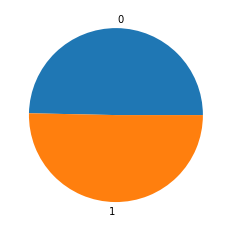

Dev Label Distribution:
No. of positive reviews: 19
No. of negative reviews: 19


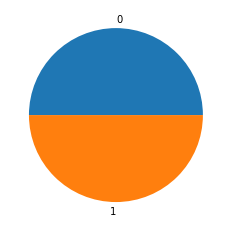

In [541]:

def split_dataset(texts, labels):
    """
    Split the dataset randomly into 80% training and 20% development set
    Make sure the splits have the same label distribution
    """
    

    train_proportion = 0.8
    y = np.array(labels)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)

    for value in values:
        value_inds = np.nonzero(y == value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))
        train_inds[value_inds[:n]] = True
        test_inds[value_inds[n:]] = True
    
    t_texts = np.array(texts)[train_inds].tolist()
    t_labels = np.array(labels)[train_inds].tolist()
    d_texts = np.array(texts)[test_inds].tolist()
    d_labels = np.array(labels)[test_inds].tolist()
    

    # return train_inds,test_inds
    return t_texts, t_labels, d_texts, d_labels


train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

print('Train Label Distribution:')
label_distribution(train_labels)

print('Dev Label Distribution:')
label_distribution(dev_labels)


### Task 1.3: Evaluation Metrics

Implementing the evaulation metrics: Accuracy, Precision, Recall and F1 score

In [542]:
### ENTER CODE HERE ###

def accuracy(predicted_labels, true_labels):
    """
    Accuracy is correct predictions / all predicitons
    """
    # sys_pos = predicted_labels.count(1)
    # sys_neg = predicted_labels.count(0)
    # gold_pos = true_labels.count(1)
    # gold_neg = true_labels.count(0)


    # false_pos = max(0, sys_pos - gold_pos)
    # false_neg = max(0, sys_neg - gold_neg)
    # true_pos = max(0, sys_pos - false_pos)
    # true_neg = max(0, sys_neg - false_neg)

    comp = np.nonzero(np.array(true_labels) != np.array(predicted_labels))[0]
    diff_val = np.array(predicted_labels)[comp]
    false_pos = np.count_nonzero(diff_val)
    false_neg = diff_val.size - false_pos
    true_pos = predicted_labels.count(1) - false_pos
    true_neg = predicted_labels.count(0) - false_neg

    
    return (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)

def precision(predicted_labels, true_labels):
    """
    Precision is True Positives / All Positives Predictions
    # """
    # sys_pos = predicted_labels.count(1)
    # sys_neg = predicted_labels.count(0)
    # gold_pos = true_labels.count(1)
    # gold_neg = true_labels.count(0)
    # print(f'predicted_labels: {predicted_labels}')
    # print(f'true lables: {true_labels}')
    # print(f'length of predicted_labels: {len(predicted_labels)} and length of true_ lables: {len(true_labels)}')

    # false_pos = max(0, sys_pos - gold_pos)
    # false_neg = max(0, sys_neg - gold_neg)
    # true_pos = max(0, sys_pos - false_pos)
    # # true_neg = max(0, sys_neg - false_neg)

    comp = np.nonzero(np.array(true_labels) != np.array(predicted_labels))[0]
    # print(f'comp: {comp}')
    diff_val = np.array(predicted_labels)[comp]
    false_pos = np.count_nonzero(diff_val)
    false_neg = diff_val.size - false_pos
    true_pos = predicted_labels.count(1) - false_pos
    true_neg = predicted_labels.count(0) - false_neg
    
   
    # print(f'precision: {true_pos/(true_pos + false_pos)}')
    return true_pos/(true_pos + false_pos)

def recall(predicted_labels, true_labels):
    """
    Recall is True Positives / All Positive Labels
    """
    # sys_pos = predicted_labels.count(1)
    # sys_neg = predicted_labels.count(0)
    # gold_pos = true_labels.count(1)
    # gold_neg = true_labels.count(0)


    # false_pos = max(0, sys_pos - gold_pos)
    # false_neg = max(0, sys_neg - gold_neg)
    # true_pos = max(0, sys_pos - false_pos)
    # # true_neg = max(0, sys_neg - false_neg)

    comp = np.nonzero(np.array(true_labels) != np.array(predicted_labels))[0]
    diff_val = np.array(predicted_labels)[comp]
    false_pos = np.count_nonzero(diff_val)
    false_neg = diff_val.size - false_pos
    true_pos = predicted_labels.count(1) - false_pos
    true_neg = predicted_labels.count(0) - false_neg
    # print(f'recall: {true_pos/(true_pos + false_neg)}')
    
    return true_pos/(true_pos + false_neg)

def f1_score(predicted_labels, true_labels):
    # print(f'predicted_labels type: {type(predicted_labels)} and true_labels type: type{true_labels}')
    # print(f'predicted_labels: {predicted_labels}')
    # print(f'true lables: {true_labels}')
    """
    F1 score is the harmonic mean of precision and recall
    """
    Recall = recall(predicted_labels, true_labels)
    Precision = precision(predicted_labels, true_labels)

   
    return (2 * Precision * Recall)/(Precision + Recall)

In [543]:
em_test_labels = [0]*6 + [1]*4
em_test_predictions = [0]*8 + [1]*2

em_test_accuracy = 0.8
em_test_precision = 1.0
em_test_recall = 0.5
em_test_f1 = 2/3

assert accuracy(em_test_predictions, em_test_labels) == em_test_accuracy
assert precision(em_test_predictions, em_test_labels) == em_test_precision 
assert recall(em_test_predictions, em_test_labels) == em_test_recall
assert f1_score(em_test_predictions, em_test_labels) == em_test_f1

print('All Test Cases Passed!')

All Test Cases Passed!


## Section 2: Baselines

It is important to come up with baselines for the classifications to compare the more complicated models with. The baselines are also useful as a debugging method for your actual classfication model.

1. Random Chance
2. Naive Bayes Classifier

### Task 2.1: Random Chance Classifier

A random chance classifier predicts the label according to the label's distribution. As an example, if the label 1 appears 70% of the times in the training set, you predict 70 out of 100 times the label 1 and label 0 30% of the times

In [544]:

def predict_random(train_labels, num_samples):
    """
    Using the label distribution, predict the label num_sample number of times
    """
    prob_of_1 = train_labels.count(1)/len(train_labels)
    prob_of_0 = train_labels.count(0)/len(train_labels)
    sampleList = [0,1]
    random_chance_output = np.random.choice(sampleList, num_samples, p = [prob_of_0, prob_of_1])
    return random_chance_output

### Task 2.2: Naive Bayes Classifier
As a preprocessing step, remove the stop words and lemmatize/stem the words of the texts. 

### Spacy Model https://spacy.io

To tokenize the text and help extract features from text, popular spaCy model is used

In [545]:

# Initialize the spacy model
nlp = spacy.load('en_core_web_sm')

In [546]:
test_string = "This is an amazing sentence"

# parse the string with spacy model
test_doc = nlp(test_string)

print('Token', 'Lemma', 'Is_Stopword?')
for token in test_doc:
    print(token, token.lemma_, token.is_stop)

Token Lemma Is_Stopword?
This this True
is be True
an an True
amazing amazing False
sentence sentence False


### Task 2.2.2: Preprocessing

Remove stopwords and lemmatize the words of a text

In [547]:
from typing import List
def pre_process(text: str) -> List[str]:
    """
    remove stopwords and lemmatize and return an array of lemmas
    """
    doc = nlp(text)
    cleaned_doc = []
    for token in doc:
        if token.is_stop:
            continue
        else:
            cleaned_doc.append(token.lemma_)


    return cleaned_doc
    
test_string = "This sentence needs to be lemmatized"

assert len({'sentence', 'need', 'lemmatize', 'lemmatiz'}.intersection(pre_process(test_string))) >= 3

print('All Test Cases Passed!')

All Test Cases Passed!


### Task 2.2.3: The Naive Bayes Class (5 Points)

The standard way of implementing classifiers like Naive Bayes is to implement the two methods: "fit" and "predict". The fit method expects the training data along with labels, and the predict method predicts the labels for the provides texts of samples.

In [548]:
import numpy as np
class NaiveBayesClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
       
        self.V = 0
        self.pos_word_occurance = {}
        self.neg_word_occurance = {}
        self.pos_token_len = 0
        self.neg_token_len = 0
  
        self.train_text_pos = []
        self.train_labels_pos = []
        self.train_text_neg = []
        self.train_labels_neg = []
        self.pos_neg_tokens = []
        self.train_texts = []

    def fit(self, train_texts, train_labels):
        """
        1. Group samples by their labels
        2. Preprocess each text
        3. Count the words of the text for each label
        """
        self.train_texts = train_texts

        # Seperate out pos and neg texts
        for j,i in enumerate(train_labels):
            if i:
                self.train_text_pos.append(self.train_texts[j])
                self.train_labels_pos.append(j)
            else:
                self.train_text_neg.append(self.train_texts[j])
                self.train_labels_neg.append(j)
        
        # preprocess pos and neg texts into tokens
        pp_train_text_pos = []
        pp_train_text_neg = []
        for l in range(len(self.train_text_pos)):
            pp_train_text_pos = pp_train_text_pos + pre_process(self.train_text_pos[l])
        for m in range(len(self.train_text_neg)):   
            pp_train_text_neg = pp_train_text_neg + pre_process(self.train_text_neg[m])

        self.pos_token_len = len(pp_train_text_pos)
        self.neg_token_len = len(pp_train_text_neg)

        # Count occurances of each token in pos and neg
        
        for word in pp_train_text_pos:
            if word in self.pos_word_occurance:
                self.pos_word_occurance[word] += 1
            else:
                self.pos_word_occurance[word] = 1

        for word in pp_train_text_neg:
            if word in self.neg_word_occurance:
                self.neg_word_occurance[word] += 1
            else:
                self.neg_word_occurance[word] = 1

        # Calculate Vocabulary

        self.pos_neg_tokens = pp_train_text_pos + pp_train_text_neg
        self.V = len(set(self.pos_neg_tokens))
    
    
    def predict(self, texts):
        """
        1. Preprocess the texts
        2. Predict the class by using the likelihood with Bayes Method and Laplace Smoothing
        """
        pp_dev_text = []
        for l in range(len(texts)):
            pp_dev_text.append(pre_process(texts[l]))
        

        # Cleaning dev text to only retain tokens present in training set
        nb_predicted_labels = []
       
        for r in range(len(pp_dev_text)):
         
            valid_dev_text = []
            valid_dev_text = list(set(self.pos_neg_tokens) & set(pp_dev_text[r]))
            
            pos_prob =[]
            neg_prob = []
            

            for w in valid_dev_text:
                if w in self.pos_word_occurance:
                    pos_prob.append((self.pos_word_occurance[w] + 1)/(self.pos_token_len + self.V))
                else:
                    pos_prob.append((0 + 1)/(self.pos_token_len + self.V))              #Laplace Smoothing
                    
            
            pos_prob_val = np.prod(np.array(pos_prob))

            for w in valid_dev_text:
                if w in self.neg_word_occurance:
                    neg_prob.append((self.neg_word_occurance[w] + 1)/(self.neg_token_len + self.V))
                else:
                    neg_prob.append((0 + 1)/(self.neg_token_len + self.V))     #Laplace Smoothing
                    
            
            neg_prob_val = np.prod(np.array(neg_prob))
            pos_prior = len(self.train_text_pos)/len(self.train_texts)
            neg_prior = len(self.train_text_neg)/len(self.train_texts)
            final_pos_prob = pos_prior * pos_prob_val
            final_neg_prob = neg_prior * neg_prob_val
            nb_predicted_labels.append(0 if final_pos_prob < final_neg_prob  else 1)
        

        return nb_predicted_labels


### Task 2.3: Baseline Results

In [549]:

### DEV SET RESULTS

testset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
print('Random Chance F1:', f1_score(testset_prediction_random.tolist(), dev_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(train_texts, train_labels)
testset_predictions_nb = naive_bayes_classifier.predict(dev_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, dev_labels))

Random Chance F1: 0.5365853658536586
Naive Bayes F1: 0.8717948717948718


In [519]:

### TEST SET RESULTS

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
print('Random Chance F1:', f1_score(testset_prediction_random.tolist(), test_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(all_texts, all_labels)
testset_predictions_nb = naive_bayes_classifier.predict(test_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, test_labels))

Random Chance F1: 0.5833333333333334
Naive Bayes F1: 0.888888888888889


## Section 3: Logistic Regression on Features

Building a logistic regression based classifier on hand-engineered features.

The following blocks have implementation required for building a Logistic Regressor.

### Task 3.0: Feature Extraction (20 points)

This is perhaps the most challenging part!

This task requires a thorough understanding of the dataset to answer the important question, "What is in the data?". It's important to go through some of the datapoints and convert the signals that might be helpful in identifying "sentiment" as features.
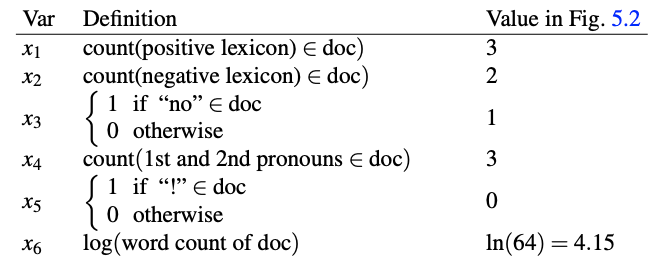

In [524]:
#Reading in positive nad negative words from the text files

pos_word_datapath = "data/positive-words.txt"
neg_word_datapath = "data/negative-words.txt"
pos_words, neg_words = [], []
with open(pos_word_datapath, "r") as file:
    for line in file:
        text = line.rstrip()
        pos_words.append(text)
with open(neg_word_datapath, "r") as file:
    for line in file:
        text = line.rstrip()
        neg_words.append(text)




In [525]:
import math

def get_pos_words(text: spacy.tokens.doc.Doc):
    s = [t.lemma_ for t in text]
    pos_in_text = [x for x in s if x in pos_words]
    return len(pos_in_text)

def get_neg_words(text: spacy.tokens.doc.Doc):
    s = [t.lemma_ for t in text]
    neg_in_text = [x for x in s if x in neg_words]
    return len(neg_in_text)

def no_present_or_not(text: spacy.tokens.doc.Doc):
    return "no" in [t.lemma_ for t in text]

def exclamation_present_or_not(text: spacy.tokens.doc.Doc):
    return "!" in [t.lemma_ for t in text]

def log_word_count(text: spacy.tokens.doc.Doc):
    return math.log(len([t.lemma_ for t in text]))

def get_1st_2nd_pronouns(text: spacy.tokens.doc.Doc):
    s = [t.tag_ for t in text]
    pronouns_in_text = [x for x in s if x == 'PRP' ]
    return len(pronouns_in_text)


def extract_features(text: spacy.tokens.doc.Doc):
    features = []

    features.append(get_pos_words(text))
    features.append(get_neg_words(text))
    features.append(no_present_or_not(text))
    features.append(exclamation_present_or_not(text))
    features.append(log_word_count(text))
    features.append(get_1st_2nd_pronouns(text))


    return features

In [526]:


def featurize_data(texts, labels):
    # print(f'labels: {labels}')
    features = [
        extract_features(doc) for doc in nlp.pipe(texts)
    ]
    return torch.FloatTensor(features), torch.FloatTensor(labels)

### Task 3.0.2: Feature Scaling

Normalizing the data to ensure the scales of the feature are consistent.

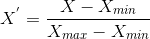

In [527]:
### ENTER CODE HERE ###

def normalize(features: torch.Tensor) -> torch.Tensor:
   
    normalized_feature = torch.nn.functional.normalize(features)

    return normalized_feature


## Training a Logistic Regression Classifier

### Pytorch logistic regression classifier

In [528]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        # We force output to be one, since we are doing binary logistic regression
        self.output_size = 1
        self.coefficients = torch.nn.Linear(input_dim, self.output_size)
        # Initialize weights. 
        initialize_weights(self.coefficients)
        
    def forward(self, features: torch.Tensor):
        # prediction is done by multipling the coefficients
        # and then take the sigmoid to turn the score as logits
        return torch.sigmoid(self.coefficients(features))

### Task 3.1: Initialize the weights.

Initialization of the parameters is an important step to ensure the SGD algorithm converges to a global optimum. Typically, different initialization methods need to be tried and compared for the accuracy it achieves wrt the development set. 

In [529]:
### ENTER CODE HERE ###

def initialize_weights(coefficients):
   
    torch.nn.init.ones_(coefficients.weight)

### Task 3.2: Logistic Loss Function

In [530]:

def logistic_loss(prediction: torch.Tensor, label: torch.Tensor) -> torch.Tensor:

    criterion = torch.nn.BCELoss(size_average= True)
    loss = criterion(prediction, label)
     
    return loss
    

### Task 3.3: Create an SGD optimizer

We have already provided the implementation of how to create the SGD optimizer

You may try different optimizers refering to the docs provided

In [253]:

def make_optimizer(model, learning_rate) -> torch.optim:
    """
    Returns an Stocastic Gradient Descent Optimizer
    See here for algorithms you can import: https://pytorch.org/docs/stable/optim.html
    """
    return torch.optim.SGD(model.parameters(), learning_rate)

### Task 3.5: Converting Logits into Predictions

In [531]:

def predict(model, features):
    with torch.no_grad():
        """
        TODO: Replace the line `raise NotImplementedError`
        with the logic of converting the logits into prediction labels (0, 1)
        """
        logits = model(features)
       
    tmp = np.concatenate(np.where(logits > 0.5, 1.0, 0.0).tolist()).ravel().tolist()
    
     
    return tmp

### Training Function

In [532]:
### DO NOT EDIT ###

from tqdm.autonotebook import tqdm
import random


def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    samples = list(zip(train_features, train_labels))
    random.shuffle(samples)
    batches = []
    for i in range(0, len(samples), batch_size):
        batches.append(samples[i:i+batch_size])
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Empty the dynamic computation graph
            features, labels = zip(*batch)
            features = torch.stack(features)
            labels = torch.stack(labels)
            optimizer.zero_grad()
            # Run the model
            logits = model(features)
            # Compute loss
            loss = logistic_loss(torch.squeeze(logits), labels)
            # In this logistic regression example,
            # this entails computing a single gradient
            loss.backward()
            # Backpropogate the loss through our model
            
            # Update our coefficients in the direction of the gradient.
            optimizer.step()
             # For logging
            losses.append(loss.item())
        
        # Estimate the f1 score for the development set
        dev_f1 = f1_score(predict(model, dev_features), dev_labels.tolist())
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print(f"Dev F1 {dev_f1}")
        
    # Return the trained model
    return model

### Task 3.6: Train the classifier

Train a logistic regressor on the hand-engineered features.

In [568]:
num_epochs = 200

train_features, train_labels_tensor = featurize_data(train_texts, train_labels)
train_features = normalize(train_features)
dev_features, dev_labels_tensor = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
model = SentimentClassifier(train_features.shape[1]) 
optimizer = make_optimizer(model, learning_rate=0.01)

trained_model = training_loop(
    num_epochs,
    16,
    train_features,
    train_labels_tensor,
    dev_features,
    dev_labels_tensor,
    optimizer,
    model
)

Training...


100%|██████████| 10/10 [00:00<00:00, 4859.02it/s]


epoch 0, loss: 0.9601301908493042
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3812.66it/s]


epoch 1, loss: 0.9417790710926056
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4105.62it/s]


epoch 2, loss: 0.9243624567985534
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4351.84it/s]


epoch 3, loss: 0.9078534185886383
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4629.99it/s]


epoch 4, loss: 0.892222785949707
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3118.21it/s]


epoch 5, loss: 0.8774394273757935
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3186.68it/s]


epoch 6, loss: 0.8634705603122711
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3611.73it/s]


epoch 7, loss: 0.8502824306488037
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3962.12it/s]


epoch 8, loss: 0.8378403186798096
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3053.51it/s]


epoch 9, loss: 0.8261090636253356
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4655.17it/s]


epoch 10, loss: 0.8150532066822052
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4350.04it/s]


epoch 11, loss: 0.8046375870704651
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3562.34it/s]


epoch 12, loss: 0.7948273599147797
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 2600.63it/s]


epoch 13, loss: 0.7855882525444031
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3772.20it/s]


epoch 14, loss: 0.7768868327140808
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4428.58it/s]


epoch 15, loss: 0.7686905086040496
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4480.14it/s]


epoch 16, loss: 0.7609679818153381
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 2314.74it/s]


epoch 17, loss: 0.7536890149116516
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3077.03it/s]


epoch 18, loss: 0.7468246161937714
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4412.73it/s]


epoch 19, loss: 0.7403472185134887
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4745.76it/s]


epoch 20, loss: 0.7342305362224579
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4166.80it/s]


epoch 21, loss: 0.7284497618675232
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3707.84it/s]


epoch 22, loss: 0.7229813158512115
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 5831.09it/s]


epoch 23, loss: 0.7178031265735626
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4717.47it/s]


epoch 24, loss: 0.7128943622112274
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3611.11it/s]


epoch 25, loss: 0.7082355201244355
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 3674.06it/s]


epoch 26, loss: 0.7038083910942078
Dev F1 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 4224.72it/s]


epoch 27, loss: 0.6995958805084228
Dev F1 0.6785714285714285


100%|██████████| 10/10 [00:00<00:00, 3031.22it/s]


epoch 28, loss: 0.6955821335315704
Dev F1 0.6785714285714285


100%|██████████| 10/10 [00:00<00:00, 4628.96it/s]


epoch 29, loss: 0.6917523503303528
Dev F1 0.6909090909090909


100%|██████████| 10/10 [00:00<00:00, 4284.71it/s]


epoch 30, loss: 0.6880928456783295
Dev F1 0.6909090909090909


100%|██████████| 10/10 [00:00<00:00, 2460.00it/s]


epoch 31, loss: 0.6845908761024475
Dev F1 0.6909090909090909


100%|██████████| 10/10 [00:00<00:00, 4585.44it/s]


epoch 32, loss: 0.681234610080719
Dev F1 0.6909090909090909


100%|██████████| 10/10 [00:00<00:00, 4492.13it/s]


epoch 33, loss: 0.678013151884079
Dev F1 0.6909090909090909


100%|██████████| 10/10 [00:00<00:00, 2807.43it/s]


epoch 34, loss: 0.6749164044857026
Dev F1 0.6909090909090909


100%|██████████| 10/10 [00:00<00:00, 3938.31it/s]


epoch 35, loss: 0.6719349384307861
Dev F1 0.6909090909090909


100%|██████████| 10/10 [00:00<00:00, 3282.70it/s]


epoch 36, loss: 0.6690602421760559
Dev F1 0.7037037037037037


100%|██████████| 10/10 [00:00<00:00, 4140.89it/s]


epoch 37, loss: 0.6662843108177186
Dev F1 0.7037037037037037


100%|██████████| 10/10 [00:00<00:00, 4524.60it/s]


epoch 38, loss: 0.6635998547077179
Dev F1 0.7037037037037037


100%|██████████| 10/10 [00:00<00:00, 4300.97it/s]


epoch 39, loss: 0.6610000789165497
Dev F1 0.7037037037037037


100%|██████████| 10/10 [00:00<00:00, 4657.75it/s]


epoch 40, loss: 0.6584788501262665
Dev F1 0.7037037037037037


100%|██████████| 10/10 [00:00<00:00, 4522.65it/s]


epoch 41, loss: 0.656030410528183
Dev F1 0.7169811320754718


100%|██████████| 10/10 [00:00<00:00, 4584.94it/s]


epoch 42, loss: 0.6536495208740234
Dev F1 0.7307692307692308


100%|██████████| 10/10 [00:00<00:00, 2738.15it/s]


epoch 43, loss: 0.6513313293457031
Dev F1 0.7450980392156863


100%|██████████| 10/10 [00:00<00:00, 2774.74it/s]


epoch 44, loss: 0.6490714073181152
Dev F1 0.76


100%|██████████| 10/10 [00:00<00:00, 2330.95it/s]


epoch 45, loss: 0.6468656182289123
Dev F1 0.76


100%|██████████| 10/10 [00:00<00:00, 4551.60it/s]


epoch 46, loss: 0.6447102785110473
Dev F1 0.76


100%|██████████| 10/10 [00:00<00:00, 4520.70it/s]


epoch 47, loss: 0.6426019728183746
Dev F1 0.76


100%|██████████| 10/10 [00:00<00:00, 3781.04it/s]


epoch 48, loss: 0.640537440776825
Dev F1 0.76


100%|██████████| 10/10 [00:00<00:00, 3787.87it/s]


epoch 49, loss: 0.6385138690471649
Dev F1 0.76


100%|██████████| 10/10 [00:00<00:00, 4699.50it/s]


epoch 50, loss: 0.6365285515785217
Dev F1 0.76


100%|██████████| 10/10 [00:00<00:00, 3271.94it/s]


epoch 51, loss: 0.6345790565013886
Dev F1 0.7346938775510204


100%|██████████| 10/10 [00:00<00:00, 3474.69it/s]


epoch 52, loss: 0.6326631367206573
Dev F1 0.75


100%|██████████| 10/10 [00:00<00:00, 4614.70it/s]


epoch 53, loss: 0.6307787716388702
Dev F1 0.75


100%|██████████| 10/10 [00:00<00:00, 3630.80it/s]


epoch 54, loss: 0.6289239943027496
Dev F1 0.7659574468085106


100%|██████████| 10/10 [00:00<00:00, 3791.98it/s]


epoch 55, loss: 0.6270971298217773
Dev F1 0.7659574468085106


100%|██████████| 10/10 [00:00<00:00, 4640.23it/s]


epoch 56, loss: 0.6252965331077576
Dev F1 0.7659574468085106


100%|██████████| 10/10 [00:00<00:00, 3413.06it/s]


epoch 57, loss: 0.6235208213329315
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 4723.32it/s]


epoch 58, loss: 0.6217685639858246
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 3194.93it/s]


epoch 59, loss: 0.6200385868549347
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 4504.68it/s]


epoch 60, loss: 0.6183297157287597
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 4048.95it/s]


epoch 61, loss: 0.6166409432888031
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 4640.23it/s]


epoch 62, loss: 0.6149712681770325
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 4486.37it/s]


epoch 63, loss: 0.6133198380470276
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 3902.04it/s]


epoch 64, loss: 0.6116858720779419
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 5268.56it/s]


epoch 65, loss: 0.6100684881210328
Dev F1 0.782608695652174


100%|██████████| 10/10 [00:00<00:00, 4014.84it/s]


epoch 66, loss: 0.6084671497344971
Dev F1 0.7555555555555555


100%|██████████| 10/10 [00:00<00:00, 3207.14it/s]


epoch 67, loss: 0.6068811655044556
Dev F1 0.7555555555555555


100%|██████████| 10/10 [00:00<00:00, 2939.45it/s]


epoch 68, loss: 0.6053099393844604
Dev F1 0.7555555555555555


100%|██████████| 10/10 [00:00<00:00, 4310.25it/s]


epoch 69, loss: 0.6037529349327088
Dev F1 0.7555555555555555


100%|██████████| 10/10 [00:00<00:00, 4316.02it/s]


epoch 70, loss: 0.6022096931934356
Dev F1 0.7727272727272727


100%|██████████| 10/10 [00:00<00:00, 4560.02it/s]


epoch 71, loss: 0.6006797134876252
Dev F1 0.7727272727272727


100%|██████████| 10/10 [00:00<00:00, 5221.99it/s]


epoch 72, loss: 0.5991625905036926
Dev F1 0.7727272727272727


100%|██████████| 10/10 [00:00<00:00, 4137.21it/s]


epoch 73, loss: 0.5976579010486602
Dev F1 0.7727272727272727


100%|██████████| 10/10 [00:00<00:00, 3394.55it/s]


epoch 74, loss: 0.5961653232574463
Dev F1 0.7727272727272727


100%|██████████| 10/10 [00:00<00:00, 4543.72it/s]


epoch 75, loss: 0.5946844458580017
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 3512.52it/s]


epoch 76, loss: 0.5932150304317474
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3987.74it/s]


epoch 77, loss: 0.5917567253112793
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4732.38it/s]


epoch 78, loss: 0.5903093039989471
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3971.50it/s]


epoch 79, loss: 0.5888725042343139
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4351.84it/s]


epoch 80, loss: 0.5874460577964783
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3353.57it/s]


epoch 81, loss: 0.5860297977924347
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4909.64it/s]


epoch 82, loss: 0.5846234500408173
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 2961.24it/s]


epoch 83, loss: 0.5832268714904785
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4704.24it/s]


epoch 84, loss: 0.5818398714065551
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3783.77it/s]


epoch 85, loss: 0.5804622590541839
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 2719.34it/s]


epoch 86, loss: 0.5790939092636108
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4779.83it/s]


epoch 87, loss: 0.5777346551418304
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4374.53it/s]


epoch 88, loss: 0.5763843417167663
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4500.33it/s]


epoch 89, loss: 0.5750428378582001
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3529.96it/s]


epoch 90, loss: 0.5737099885940552
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 5012.31it/s]


epoch 91, loss: 0.5723857462406159
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3034.07it/s]


epoch 92, loss: 0.5710699319839477
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4436.54it/s]


epoch 93, loss: 0.5697624742984772
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4260.77it/s]


epoch 94, loss: 0.5684632420539856
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3093.14it/s]


epoch 95, loss: 0.5671721279621125
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4317.79it/s]


epoch 96, loss: 0.5658890843391419
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4288.65it/s]


epoch 97, loss: 0.5646139979362488
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4977.22it/s]


epoch 98, loss: 0.5633467555046081
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4771.68it/s]


epoch 99, loss: 0.5620873212814331
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3204.94it/s]


epoch 100, loss: 0.5608355402946472
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3271.18it/s]


epoch 101, loss: 0.559591394662857
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3502.84it/s]


epoch 102, loss: 0.5583547830581665
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3554.80it/s]


epoch 103, loss: 0.5571256101131439
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 2751.08it/s]


epoch 104, loss: 0.5559038758277893
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4297.44it/s]


epoch 105, loss: 0.5546894490718841
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 4323.13it/s]


epoch 106, loss: 0.5534822821617127
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3705.22it/s]


epoch 107, loss: 0.55228231549263
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 2876.95it/s]


epoch 108, loss: 0.551089471578598
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3286.30it/s]


epoch 109, loss: 0.549903666973114
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 3313.56it/s]


epoch 110, loss: 0.548724889755249
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 4595.49it/s]


epoch 111, loss: 0.5475530683994293
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 4003.34it/s]


epoch 112, loss: 0.5463881134986878
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 3065.56it/s]


epoch 113, loss: 0.5452299952507019
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 4563.99it/s]


epoch 114, loss: 0.5440786689519882
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 4452.55it/s]


epoch 115, loss: 0.5429340481758118
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 4256.02it/s]


epoch 116, loss: 0.5417961061000824
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 4147.85it/s]


epoch 117, loss: 0.5406647861003876
Dev F1 0.744186046511628


100%|██████████| 10/10 [00:00<00:00, 4960.74it/s]


epoch 118, loss: 0.5395400136709213
Dev F1 0.761904761904762


100%|██████████| 10/10 [00:00<00:00, 3081.78it/s]


epoch 119, loss: 0.538421756029129
Dev F1 0.761904761904762


100%|██████████| 10/10 [00:00<00:00, 4618.77it/s]


epoch 120, loss: 0.5373099982738495
Dev F1 0.7804878048780488


100%|██████████| 10/10 [00:00<00:00, 3746.92it/s]


epoch 121, loss: 0.5362046390771866
Dev F1 0.7804878048780488


100%|██████████| 10/10 [00:00<00:00, 4059.92it/s]


epoch 122, loss: 0.5351056337356568
Dev F1 0.7500000000000001


100%|██████████| 10/10 [00:00<00:00, 4344.18it/s]


epoch 123, loss: 0.5340129166841507
Dev F1 0.7500000000000001


100%|██████████| 10/10 [00:00<00:00, 4048.95it/s]


epoch 124, loss: 0.5329264819622039
Dev F1 0.7500000000000001


100%|██████████| 10/10 [00:00<00:00, 4779.83it/s]


epoch 125, loss: 0.5318462878465653
Dev F1 0.7500000000000001


100%|██████████| 10/10 [00:00<00:00, 4680.10it/s]


epoch 126, loss: 0.5307722508907318
Dev F1 0.7500000000000001


100%|██████████| 10/10 [00:00<00:00, 3796.78it/s]


epoch 127, loss: 0.5297043591737747
Dev F1 0.7500000000000001


100%|██████████| 10/10 [00:00<00:00, 4739.33it/s]


epoch 128, loss: 0.5286425203084946
Dev F1 0.7500000000000001


100%|██████████| 10/10 [00:00<00:00, 2963.75it/s]


epoch 129, loss: 0.5275867402553558
Dev F1 0.7500000000000001


100%|██████████| 10/10 [00:00<00:00, 4791.85it/s]


epoch 130, loss: 0.526536974310875
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4706.36it/s]


epoch 131, loss: 0.525493147969246
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 2970.05it/s]


epoch 132, loss: 0.5244551926851273
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3244.61it/s]


epoch 133, loss: 0.5234231382608414
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3640.26it/s]


epoch 134, loss: 0.5223968803882599
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4741.47it/s]


epoch 135, loss: 0.5213764190673829
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3088.13it/s]


epoch 136, loss: 0.5203616589307785
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3666.03it/s]


epoch 137, loss: 0.5193526417016983
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3996.86it/s]


epoch 138, loss: 0.5183492720127105
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3130.78it/s]


epoch 139, loss: 0.5173515260219574
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4602.05it/s]


epoch 140, loss: 0.5163593411445617
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3753.96it/s]


epoch 141, loss: 0.515372684597969
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 2995.93it/s]


epoch 142, loss: 0.5143915504217148
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4424.84it/s]


epoch 143, loss: 0.5134158432483673
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4203.55it/s]


epoch 144, loss: 0.5124455571174622
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3251.15it/s]


epoch 145, loss: 0.5114806532859802
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4538.80it/s]


epoch 146, loss: 0.5105211049318313
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 5356.03it/s]


epoch 147, loss: 0.509566867351532
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 5794.04it/s]


epoch 148, loss: 0.5086179077625275
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4882.78it/s]


epoch 149, loss: 0.5076741695404052
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3559.93it/s]


epoch 150, loss: 0.5067356258630753
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 5831.09it/s]


epoch 151, loss: 0.5058022290468216
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3919.91it/s]


epoch 152, loss: 0.5048739522695541
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4697.40it/s]


epoch 153, loss: 0.5039507746696472
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4561.51it/s]


epoch 154, loss: 0.5030326247215271
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3239.35it/s]


epoch 155, loss: 0.502119505405426
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4572.45it/s]


epoch 156, loss: 0.5012113451957703
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4764.09it/s]


epoch 157, loss: 0.500308158993721
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 5176.24it/s]


epoch 158, loss: 0.4994098573923111
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4646.40it/s]


epoch 159, loss: 0.4985164523124695
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3188.86it/s]


epoch 160, loss: 0.49762789011001585
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4593.48it/s]


epoch 161, loss: 0.4967441111803055
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4057.17it/s]


epoch 162, loss: 0.49586513042449953
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4173.44it/s]


epoch 163, loss: 0.494990873336792
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 5960.36it/s]


epoch 164, loss: 0.4941213488578796
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3913.69it/s]


epoch 165, loss: 0.4932565003633499
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 5060.69it/s]


epoch 166, loss: 0.492396280169487
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 5345.11it/s]


epoch 167, loss: 0.4915406733751297
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3516.35it/s]


epoch 168, loss: 0.4906896412372589
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4502.26it/s]


epoch 169, loss: 0.48984316289424895
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4834.93it/s]


epoch 170, loss: 0.4890012085437775
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 2055.93it/s]


epoch 171, loss: 0.4881637305021286
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1541.74it/s]


epoch 172, loss: 0.48733069896698
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 971.53it/s]


epoch 173, loss: 0.4865021020174026
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 912.90it/s]


epoch 174, loss: 0.4856778889894485
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 2749.64it/s]


epoch 175, loss: 0.4848580867052078
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1037.53it/s]


epoch 176, loss: 0.48404256999492645
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 4636.13it/s]


epoch 177, loss: 0.4832313805818558
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 7439.35it/s]


epoch 178, loss: 0.4824244797229767
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1684.12it/s]


epoch 179, loss: 0.48162178993225097
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1585.75it/s]


epoch 180, loss: 0.48082333505153657
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1097.07it/s]


epoch 181, loss: 0.48002913892269133
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1016.26it/s]


epoch 182, loss: 0.47923905253410337
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1032.75it/s]


epoch 183, loss: 0.47845307290554046
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 3427.84it/s]


epoch 184, loss: 0.477671229839325
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 661.90it/s]


epoch 185, loss: 0.47689343988895416
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 365.79it/s]


epoch 186, loss: 0.47611968517303466
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 643.04it/s]


epoch 187, loss: 0.4753499686717987
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1286.04it/s]


epoch 188, loss: 0.4745842307806015
Dev F1 0.7692307692307692


100%|██████████| 10/10 [00:00<00:00, 1720.60it/s]


epoch 189, loss: 0.47382246851921084
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 2676.82it/s]


epoch 190, loss: 0.47306463718414304
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 2002.34it/s]


epoch 191, loss: 0.47231073677539825
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 1290.12it/s]


epoch 192, loss: 0.47156071066856386
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 1893.85it/s]


epoch 193, loss: 0.47081456184387205
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 3373.80it/s]


epoch 194, loss: 0.47007225155830384
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 2726.94it/s]


epoch 195, loss: 0.4693337380886078
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 2701.12it/s]


epoch 196, loss: 0.46859904527664187
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 1575.09it/s]


epoch 197, loss: 0.46786806881427767
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 3535.32it/s]


epoch 198, loss: 0.4671408474445343
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 3094.06it/s]

epoch 199, loss: 0.46641733050346373
Dev F1 0.8


### Task 3.7: Get the predictions on the Test Set using the Trained model and print the F1 score

In [569]:
### DEV SET RESULTS

dev_features, dev_labels = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, dev_features), dev_labels.tolist()))
print('F1-score', f1_score(predict(trained_model, dev_features), dev_labels.tolist()))

Logistic Regression Results:
Accuracy: 0.7894736842105263
F1-score 0.8


In [570]:
### TEST SET RESULTS

test_features, test_labels = featurize_data(test_texts, test_labels)
test_features = normalize(test_features)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels.tolist()))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels.tolist()))

Logistic Regression Results:
Accuracy: 0.9
F1-score 0.9019607843137256


### Experiment Results

Table summarizing all the different experiment results for various parameter choices

|Approach                 |F1-score   | Accuracy  | Epochs    | Batch Size| Learning Rate |Test set Result
|-------------------------|-----------|-----------|-----------|-----------|---------------|---------------|
|Random Classifier        |   0.583   |     -     |    -      |    -      |    -          |
|Naive Bayes Classifier   |   0.88    |     -     |    -      |    -      |    -          |
|Logistic Regression      |   0.90    |   0.9     |   100     |    16     |    0.01       |   yes         |
|Logistic Regression      |   0.92    |   0.92     |   100     |    16     |    0.1       |   yes         |
|Logistic Regression      |   0.923    |   0.92     |   100     |    16     |    1       |   yes         |
|Logistic Regression      |   0.923    |   0.92     |   50     |    16     |    1       |   yes         |